### Tryout model Pytorch

In [1]:
#!pip install pytorch-ignite
#!pip install -e /workspace/VisionWorks

#!nvidia-smi               #shell ?
#!nvcc --version           #shell ?#
#!pip install tqdm
#!pip install sklearn
#!pip install wandb --upgrade
#!pip install seaborn

In [2]:
import wandb
from ignite.contrib.handlers.wandb_logger import *
from ignite.contrib.engines.common import * # does contain the setup_wandb_logging
import os
import seaborn as sns

import ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix, Precision, Recall
from ignite.handlers import ModelCheckpoint, EarlyStopping

from PIL import Image
from read_lapchol import LapcholDataset
from matplotlib.pyplot import imshow
#from transforms import ReadPILImage
import torch
from torch.optim import Adam
from torch.optim import SGD 
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np

import random

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
#import sklearn
#from sklearn.model_selection import KFold

from visionworks.transformation.loading.image_loading import LoadPILImage
from visionworks.transformation.image.image_transforms import ResizePILImage, ResizeNumpyImage, CenterCropTorchvision, ResizeTorchvision 
from visionworks.transformation import TorchvisionTformWrapper

from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor

from transforms import LabelToInt, LabelToTensor, DicttoImageandLabel 



In [3]:
wandb.login()
#!wandb login <13a1f666958082496c4b39a10519f6db055b76d3>
#!wandb login --relogin


wandb: Currently logged in as: jnjsurgery (use `wandb login --relogin` to force relogin)


True

In [4]:
wandb.init(project='project1', 
        entity='rubyegging',
    name="classify_difficulty",
    config={  
        "learning_rate": 0.0001,
        "epochs": 20,
        "batch_size": 32,
        "classes": 2,
        "loss_function": "BCELoss",
        "optimizer": "SGD",
        "architecture": "Resnet50",
        "dataset": "Lapchol_dataset"},
    tags=["pytorch-ignite", "lapchol", "first_run", "Gallbladder, 2 classes"]
)

config = wandb.config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class_labels = [1,2]

# define transform
tform = Compose([LoadPILImage(fields=['frame_path']),ResizePILImage(fields=['frame_path'], width=256, height=256), 
                 CenterCropTorchvision(fields=['frame_path'], width=224, height=224),
                 TorchvisionTformWrapper(fields=['frame_path'], transform=ToTensor()), 
                 TorchvisionTformWrapper(fields=['frame_path'],transform=transforms.Normalize(mean=[0.355,0.258,0.238], std=[0.250, 0.192, 0.175])),
                 LabelToInt(fields=['label'], labels=class_labels), LabelToTensor(fields=['label']), 
                 DicttoImageandLabel(image=['frame_path'], label=['label']) ])   
                 #])  #

print('The dataset:')
lapchol_train = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[88,92,94,95,156,97,98,102,103,172,215,105,106,107,109,110,120,125,127,150,152,224,226,227,228,242,251,286,289,301,302,304,309,310,316,336,348,349,356,357,358,360,367,373,407,428,444,537], sample_rate=1, transform=tform) #70% # 
#lapchol_train = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[88,89,92], sample_rate=1, transform=tform) #70% # 
lapchol_val = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[160,180,292,189,205,214,89,315], sample_rate=1, transform=tform) #70% # 

# split dataset in 'train' and 'validation' set
#from torch.utils.data import random_split
#torch.manual_seed(42)
# val_size = int(len(dataset)/8) # % of length of dataset?
#train_size = len(dataset) - val_size
#lapchol_train, lapchol_val = random_split(dataset, [train_size, val_size])
#lapchol_val = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[152,156,160,172,180,189,205,214,215,220,224], sample_rate=1, transform=tform) 

print('Number of samples in train set:' + str(lapchol_train.__len__()))
print('Number of samples in validation set:' + str(lapchol_val.__len__()))

trainloader = DataLoader(lapchol_train, config.batch_size, shuffle=True, num_workers=0)
valloader = DataLoader(lapchol_val, config.batch_size, shuffle=True, num_workers=0)

# The test set
print('The test set:')
lapchol_test = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[139,144,111,113,115,118,119,351,354,355], sample_rate=1, transform=tform) 
print('Number of samples in test set:' + str(lapchol_test.__len__()))
testloader = DataLoader(lapchol_val, config.batch_size, shuffle=False, num_workers=0)

The dataset:
Cannot find video frames for video 537
! Removed 185 samples with label excl
! Removed 1512 samples with label 0
! Changed 1890 samples from 3 to 2
! Removed 39 samples with label excl
! Removed 110 samples with label 0
! Changed 315 samples from 3 to 2
Number of samples in train set:8214
Number of samples in validation set:2223
The test set:
! Removed 182 samples with label excl
! Removed 522 samples with label 0
! Changed 1035 samples from 3 to 2
Number of samples in test set:1915


(tensor([[[-1.1690, -1.1533, -1.1533,  ..., -1.1690, -1.1690, -1.1690],
         [-1.1690, -1.1533, -1.1533,  ..., -1.1690, -1.1690, -1.1690],
         [-1.1690, -1.1533, -1.1533,  ..., -1.1690, -1.1690, -1.1690],
         ...,
         [-1.1533, -1.1690, -1.1690,  ..., -1.1376, -1.1376, -1.1690],
         [-1.1376, -1.1690, -1.1690,  ..., -1.1533, -1.1533, -1.1690],
         [-1.1690, -1.1690, -1.1690,  ..., -1.1376, -1.1533, -1.1533]],

        [[-1.0170, -0.9965, -0.9965,  ..., -1.0170, -1.0170, -1.0170],
         [-1.0170, -0.9965, -0.9965,  ..., -1.0170, -1.0170, -1.0170],
         [-1.0170, -0.9965, -0.9965,  ..., -1.0170, -1.0170, -1.0170],
         ...,
         [-0.9965, -1.0170, -1.0170,  ..., -0.9761, -0.9761, -1.0170],
         [-0.9761, -1.0170, -1.0170,  ..., -0.9965, -0.9965, -1.0170],
         [-1.0170, -1.0170, -1.0170,  ..., -0.9761, -0.9965, -0.9965]],

        [[-1.0015, -0.9790, -0.9790,  ..., -1.0015, -1.0015, -1.0015],
         [-1.0015, -0.9790, -0.9790,  ..., -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    2     1     2     1     1     1     2     2     1     1     2     1     1     1     1     2     2     1     1     1     2     2     1     1     2     1     2     1     1     2     1     2
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32, 1])


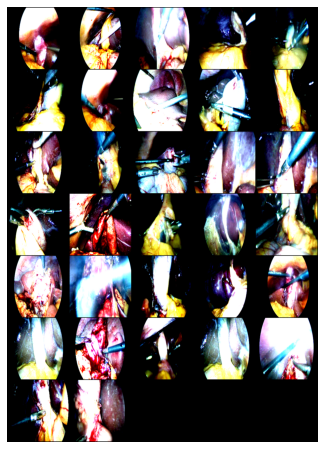

In [6]:
## Get one sample from the dictionary and show image
sample = lapchol_train.__getitem__(10)
print(sample)

# Visualize a batch of data
import matplotlib.pyplot as plt
for images, labels in trainloader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    #print(f"One Batch Labels: {labels}")
    imshow(torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0))
    print(' '.join('%5s' % class_labels[int(labels[j])] for j in range(config.batch_size)))
    break
    
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#print(train_features)

## Get one sample from the dictionary and show image
#sample = lapchol_train.__getitem__(20)
#print(sample)
img, label = lapchol_train.__getitem__(20)
img = img.numpy().transpose((1, 2, 0))
imshow(img)

## show multiple images
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(2, 2))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    length = lapchol_train.__len__()
    sample_idx = torch.randint(length, size=(1,)).item()
    img, label = lapchol_train.__getitem__(sample_idx)
    img = img.numpy().transpose((1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

## read image from path (without transform applied)
#pil_img = Image.open(sample['frame_path']).convert('RGB')
import matplotlib.pyplot as plt
import numpy as np



class_count = {}
for _, index in lapchol_train:
    label = class_labels[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

In [7]:
# label distribution in train set
total = 0
#counter_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0} #2: 0, 3: 0, 4: 0
counter_dict = {0: 0, 1: 0} #2: 0, 3: 0, 4: 0
for i in range(lapchol_train.__len__()):
    sample = lapchol_train.__getitem__(i)
    label = sample[1].numpy()
    counter_dict[int(label)] += 1
    total += 1

print(counter_dict)

for i in counter_dict:
    print(f"{i}: {counter_dict[i] / total * 100}")

total_nr_of_samples = lapchol_train.__len__()
print(f' Total number of samples in train set: {total_nr_of_samples}')


{0: 3871, 1: 4343}
0: 47.126856586316045
1: 52.873143413683955
 Total number of samples in train set: 8214


In [8]:
total = 0
counter_dict2 = {0: 0, 1: 0} #2: 0, 3: 0, 4: 0
for i in range(lapchol_val.__len__()):
    sample = lapchol_val.__getitem__(i)
    label = sample[1].numpy()
    counter_dict2[int(label)] += 1
    total += 1

print(counter_dict2)

for i in counter_dict2:
    print(f"{i}: {counter_dict2[i] / total * 100}")

total_nr_of_samples = lapchol_val.__len__()
print(f' Total number of samples in val set: {total_nr_of_samples}')

{0: 1537, 1: 686}
0: 69.14080071974809
1: 30.859199280251914
 Total number of samples in val set: 2223


In [9]:
total = 0
counter_dict3 = {0: 0, 1: 0} #2: 0, 3: 0, 4: 0
for i in range(lapchol_test.__len__()):
    sample = lapchol_test.__getitem__(i)
    label = sample[1].numpy()
    counter_dict3[int(label)] += 1
    total += 1

print(counter_dict3)

for i in counter_dict3:
    print(f"{i}: {counter_dict3[i] / total * 100}")

total_nr_of_samples = lapchol_test.__len__()
print(f' Total number of samples in test set: {total_nr_of_samples}')

{0: 654, 1: 1261}
0: 34.15143603133159
1: 65.8485639686684
 Total number of samples in test set: 1915


### label distribution for Adhesions (1,2) 
{0: 5273, 1: 5879, 2: 0, 3: 0, 4: 0}
0: 47.28%
1: 52.71%
2: 0.0
3: 0.0
4: 0.0
 Total number of samples in train set: 11152
### label distribution for Adhesions (1,2,3) (when label=1 --> 0, label=2 --> 1, label=3 --> 2)
{0: 3398, 1: 3657, 2: 2412, 3: 0, 4: 0}
0: 35.89%
1: 38.62%
2: 25.47%
3: 0.0%
4: 0.0%
 Total number of samples in train set: 9467
 
### label distribution for Gallbladder (1,2,3) (when label=1 --> 0, label=2 --> 1, label=3 --> 2)
{0: 4311, 1: 2044, 2: 2665, 3: 0, 4: 0}
0: 47.79%
1: 22.66%
2: 29.54%
3: 0.0%
4: 0.0%
 Total number of samples in train set: 9020

### label distribution for G_A_Grade 
{0: 2433, 1: 3773, 2: 4005, 3: 0, 4: 0}
0: 23.827245127803348
1: 36.95034766428362
2: 39.22240720791304
3: 0.0
4: 0.0
 Total number of samples in train set: 10211

Dataset: 8214 training samples & 2223 testing samples

Distribution of classes in dataset:


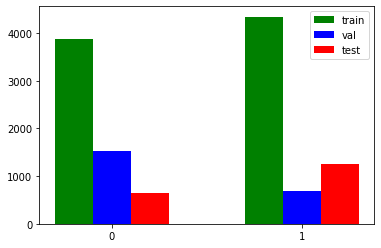

In [10]:
import matplotlib.pyplot as plt

print('Dataset: %d training samples & %d testing samples\n' % (lapchol_train.__len__(), lapchol_val.__len__()))

print('Distribution of classes in dataset:')
X = np.arange(len(counter_dict))
Y = np.arange(len(counter_dict2))
Z = np.arange(len(counter_dict3))
fig, ax = plt.subplots()
ax.bar(X-0.2, counter_dict.values(), width=0.2, color='g',align='center',label='train')
ax.bar(Y, counter_dict2.values(), width=0.2, color='b',align='center',label='val')
ax.bar(Z+0.2, counter_dict3.values(), width=0.2, color='r',align='center',label='test')
ax.legend()
plt.xticks(X, counter_dict.keys())
plt.savefig('ClassDistribution_A2.png',dpi=400)
plt.show()



In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
#for binary classification:
model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, out_features=1,
                                               bias=True), nn.Sigmoid()) 
#print(model)


#for multiple class classification
#model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, out_features=3, bias=True))
model.to(device)

#for param in model.parameters():
#    param.requires_grad = False   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
from ignite.metrics.metric import Metric
from ignite.exceptions import NotComputableError


class BinaryAccuracy(Metric):
    """
    Calculates the binary accuracy.

    - `update` must receive output of the form `(y_pred, y)`.
    - `y_pred` must be in the following shape (batch_size, ...) and it's elements must be between 0 and 1.
    - `y` must be in the following shape (batch_size, ...)
    """
    def reset(self):
        self._num_correct = 0
        self._num_examples = 0

    def update(self, output):
        y_pred, y = output
        correct = torch.eq(torch.round(y_pred).type(y.type()), y).view(-1)
        self._num_correct += torch.sum(correct).item()
        self._num_examples += correct.shape[0]

    def compute(self):
        if self._num_examples == 0:
            raise NotComputableError('BinaryAccuracy must have at least one example before it can be computed')
        return self._num_correct / self._num_examples

In [13]:
def show_images(batch_imgs,y_pred,y_thruth):
    batch, c, h, w = batch_imgs.shape
    images = []
    import matplotlib.pyplot as plt
    
    for i in range(batch):
        # Load image in batch
        arr = batch_imgs[i]                                                   #1
        inv_normalize = transforms.Normalize(mean=[-0.355/0.250, -0.258/0.192, -0.238/0.175], std=[1/0.250, 1/0.192, 1/0.175]) #1
        inv_ndarr = inv_normalize(arr)
        label_pred = y_pred[i]                          
        label_truth = y_thruth[i]                         
        img=plt.imshow(inv_ndarr.permute(1, 2, 0)  )
        plt.title(f"Y truth: [{label_truth}] Y pred: [{label_pred}]")

        # Save image to list of visualizations
        images.append(img)  
        
    return images


In [14]:
from PIL import Image, ImageFont, ImageDraw 
def show_images_2(batch_imgs,y_pred,y_thruth):
    batch, c, h, w = batch_imgs.shape
    images = []
    import matplotlib.pyplot as plt
    
    for i in range(batch):
        # Load image in batch
        arr = batch_imgs[i]                                                   
        inv_normalize = transforms.Normalize(mean=[-0.355/0.250, -0.258/0.192, -0.238/0.175], std=[1/0.250, 1/0.192, 1/0.175]) 
        inv_ndarr = inv_normalize(arr)
        unndarr = inv_ndarr.mul(255).clamp_(0, 255).to('cpu',torch.uint8).numpy()     #1
        unndarr = np.transpose(unndarr,(1,2,0))                          #1
        img = Image.fromarray(unndarr)
        label_pred = y_pred[i]                           
        label_truth = y_thruth[i]                        
        p = np.argmax(label_pred, axis=None, out=None)   # get the idx of the highest value  can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
        label_pred[p]                                    # get the hightest softmax value of the label
        draw = ImageDraw.Draw(img)
        text =f"Y truth: [{label_truth}] Y pred: [{label_pred}]"
        draw.text((5, 5), text) #align ="left"
        images.append(img)  
        
    return images


In [15]:
def binary_one_hot_output_transform(output):
    y_pred, y = output
    y_pred = torch.sigmoid(y_pred).round().long()
    y_pred = ignite.utils.to_onehot(y_pred, 2)
    y = y.long()
    return y_pred, y

def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.round(y_pred)
    return y_pred, y



In [16]:
import matplotlib.pyplot as plt
#optimizer = Adam(model.parameters(), config.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer =  SGD(model.parameters(),lr=config.learning_rate, momentum=0.9,weight_decay=0)
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
epochs = config.epochs
   
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

# TODO: add ConfusionMatrix, Precision, Recall
metrics = {'accuracy':BinaryAccuracy(), 
           'loss':Loss(criterion), 
           'cm':ConfusionMatrix(num_classes=len(class_labels),average=None,output_transform=binary_one_hot_output_transform),   
           'precision':Precision(output_transform=binary_one_hot_output_transform),
           'recall':Recall(output_transform=binary_one_hot_output_transform)}

# For multilabel cases:
#precision = Precision(average=False)
#recall = Recall(average=False)
#F1 = precision * recall * 2 / (precision + recall + 1e-20)
#F1 = MetricsLambda(lambda t: torch.mean(t).item(), F1)

evaluator = create_supervised_evaluator(model, metrics=metrics, device=device) 

log_interval =5

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    epoch = engine.state.epoch
    max_batches = engine.state.epoch_length
    batch_nr = engine.state.iteration
    batch_nr = batch_nr - (epoch - 1) * max_batches
    loss = engine.state.output
    wandb.log({"train loss": loss})
    print(f'Epoch[{epoch}] Batch[{batch_nr}/{max_batches}] Loss: {loss:.4f}')
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")
    wandb.log({"training loss": metrics['loss']})
    wandb.log({"training accuracy": metrics['accuracy']})
    
    cm2 = metrics['cm']
    cm2 = cm2.numpy()
    cm2 = cm2.astype(int)
    fig2, ax2 = plt.subplots(figsize=(config.classes,config.classes))  
    ax2 = plt.subplot()
    sns.heatmap(cm2, annot=True, ax=ax2, fmt="d", cmap="YlGnBu")
    # labels, title and ticks
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels') 
    ax2.set_title('Confusion Matrix Training') 
    ax2.xaxis.set_ticklabels(class_labels, rotation=-45)
    ax2.yaxis.set_ticklabels(class_labels,rotation=45)
    plt.rc('xtick', labelsize=6)
    plt.rc('ytick', labelsize=6)
    wandb.log({'CM_train': wandb.Image(ax2)})
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(valloader)
    #pred, y = val_evaluator.state.output
    metrics = evaluator.state.metrics
    validation_acc = metrics["accuracy"]
    precision = metrics['precision']    # = TP / (TP + FP)
    print(f"Precision: {precision}")
    #precision = precision[3].tolist()
    recall = metrics['recall']          # = TP / (TP + FN)
    print(f"Recall: {recall}")
    #recall = recall[3].tolist()
    print("Epoch: {} Validation accuracy: {:.2f}".format(trainer.state.epoch, validation_acc))
    wandb.log({"validation loss": metrics['loss']})
    wandb.log({"validation accuracy": metrics['accuracy']})
    
    # get prediction and real label
    pred, y = evaluator.state.output
    # get the last batch images
    batch_imgs = evaluator.state.batch[0]     #[0]  
    print(f"Shape of batch: {batch_imgs.shape}")                       # torch.Size([256, 3, 224, 224])
    #print(f"pred: {pred[-5:]}")   
    #print(f"y: {y[-5:]}")
    # produce images from batch inputs, with annotations
    batch_anns=show_images_2(batch_imgs[-5:],pred[-5:].to('cpu'),y[-5:])
    #print(batch_imgs)
    #print(batch_anns)                                                   # no shape! list
    #print(len(batch_anns))
    wandb.log({'Images with predictions': [wandb.Image(im) for im in batch_anns],'Precision:': precision}) #'Recall:': recall
    
#how to save the model?
#from ignite.handlers import ModelCheckpoint
#handler = ModelCheckpoint('/tmp/models', 'myprefix', n_saved=2, create_dir=True)
#trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), handler, {'mymodel': model})


    

In [17]:
wandb.watch(model,criterion,log=all,log_freq=10)

In [ ]:
trainer.run(trainloader, max_epochs=epochs)

Epoch[1] Batch[5/257] Loss: 0.7111
Epoch[1] Batch[10/257] Loss: 0.7170
Epoch[1] Batch[15/257] Loss: 0.7134
Epoch[1] Batch[20/257] Loss: 0.6996
Epoch[1] Batch[25/257] Loss: 0.7099
Epoch[1] Batch[30/257] Loss: 0.7183
Epoch[1] Batch[35/257] Loss: 0.6586
Epoch[1] Batch[40/257] Loss: 0.7074
Epoch[1] Batch[45/257] Loss: 0.6351
Epoch[1] Batch[50/257] Loss: 0.6432
Epoch[1] Batch[55/257] Loss: 0.6568
Epoch[1] Batch[60/257] Loss: 0.5891
Epoch[1] Batch[65/257] Loss: 0.6523
Epoch[1] Batch[70/257] Loss: 0.6520
Epoch[1] Batch[75/257] Loss: 0.6174
Epoch[1] Batch[80/257] Loss: 0.6109
Epoch[1] Batch[85/257] Loss: 0.6414
Epoch[1] Batch[90/257] Loss: 0.6056
Epoch[1] Batch[95/257] Loss: 0.5792
Epoch[1] Batch[100/257] Loss: 0.5972
Epoch[1] Batch[105/257] Loss: 0.5826
Epoch[1] Batch[110/257] Loss: 0.5879
Epoch[1] Batch[115/257] Loss: 0.5938
Epoch[1] Batch[120/257] Loss: 0.5506
Epoch[1] Batch[125/257] Loss: 0.5741
Epoch[1] Batch[130/257] Loss: 0.5416
Epoch[1] Batch[135/257] Loss: 0.5427
Epoch[1] Batch[140/25

In [ ]:
#checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
#torch.save(checkpoint, 'Gallbladder_2classes.pth')
#wandb.save("/workspace/model.onnx")

In [ ]:
#model = torch.load('Checkpoint.pth')
#model.eval()


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    lss = metrics['loss']           #nll
    precision = metrics['precision']    # = TP / (TP + FP)
    precision = precision[3].tolist()
    recall = metrics['recall']          # = TP / (TP + FN)
    recall = recall[3].tolist()
    F1 = (2 * precision * recall / (precision + recall))
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 score:', F1)
    tqdm.write("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
        .format(engine.state.epoch, avg_accuracy, lss)) #, precision, recall
    pbar.n = pbar.last_print_n = 0
    wandb.log({"validation loss": lss})
    wandb.log({"validation accuracy": avg_accuracy})
    #wandb.log({"validation precision": precision})
    #wandb.log({"validation recall": recall})
        
    # get prediction and real label
    pred, y = val_evaluator.state.output
    # get the last batch images
    batch_imgs = val_evaluator.state.batch[0]     #[0]  
    print(batch_imgs.shape)                       # torch.Size([256, 3, 224, 224])
    batch_imgs2 = batch_imgs
    print(pred[-5:])   
    print(y[-5:])
    # produce images from batch inputs, with annotated 
    batch_anns=produce_images(batch_imgs[-5:],pred[-5:].to('cpu'),y[-5:])
    print(batch_anns)                                                   # no shape! list
    print(len(batch_anns)
    wandb.log({'imgs of validation': [wandb.Image(im) for im in batch_anns]})
    torch.onnx.export(model,batch_imgs2.to(device),"/workspace/model/onnx")
    wandb.save("/workspace/model.onnx")
          
@trainer.on(Events.COMPLETED)
def log_test_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    fig, ax = plt.subplots(figsize=(config.classes,config.classes))  
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="d", cmap="YlGnBu")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(class_labels,rotation=90)
    ax.yaxis.set_ticklabels(class_labels,rotation=0)